## MNIST 机器学习

### 导入第三方模块

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### 导入数据集

In [2]:
import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
## 数据集被划分为60000行的训练数据集(mnist.train)、5000行的交叉验证集(mnist.validation) 和 10000行的测试数据集(mnist.test)
print('Training set', mnist.train.images.shape, mnist.train.labels.shape)
print('Validation set', mnist.validation.images.shape, mnist.validation.labels.shape)
print('Test set', mnist.test.images.shape, mnist.test.labels.shape)

('Training set', (55000, 784), (55000, 10))
('Validation set', (5000, 784), (5000, 10))
('Test set', (10000, 784), (10000, 10))


## 回归模型

### 实现回归模型

In [5]:
x = tf.placeholder("float", [None, 784])  # 占位符, 输入
W = tf.Variable(tf.zeros([784,10]))   # 权值
b = tf.Variable(tf.zeros([10]))    # 偏置
y = tf.nn.softmax(tf.matmul(x,W) + b)  #激活函数

### 训练模型

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
y_ =  tf.placeholder("float", [None,10])   #占位符，输出
cross_entropy = -tf.reduce_sum(y_ * tf.log(y))    #交叉熵
## 梯度下降，以0.01 的学习率最小化交叉熵
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
for i in range(1000):
     batch_xs, batch_ys = mnist.train.next_batch(100)   #随机抓取100个批处理数据点训练
     sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys}) # 训练，将抓取的数据集填充到x 和 y_

### 评估模型

In [7]:
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float")) 
print sess.run(accuracy,feed_dict={x: mnist.test.images, y_:mnist.test.labels})

0.9187


## 卷积神经网络

In [8]:
x_image = tf.reshape(x, [-1,28,28,1])

In [9]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  
# stride: 每个方向上的滑窗步长，默认顺序为：[batch, in_height, in_width, in_channels]

In [10]:
# 第一层卷积层，relu 作为激活函数， max_pool
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))  #truncated_normal 正太分布 32 个 (5*5)，标准差为0.1
b_conv1 = tf.Variable(tf.constant(0.1, shape = [32]))
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [11]:
# 第二次卷积层， relu 作为激活函数, max_pool
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape = [64]))
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [12]:
# full connection layers, relu 
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
W_fc1 = tf.Variable(tf.truncated_normal([7 * 7 * 64, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape = [1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [13]:
# Dropout layers
keep_prob = tf.placeholder("float")       # 将keep_prob 占位，运行的时候传入
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [14]:
# full connection layers,  softmax  
W_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape = [10]))
y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [15]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))   # 损失函数是目标类别和预测类别之间的交叉熵,将每一副图像求和
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)  ## 梯度下降，以1e-4 的学习率最小化交叉熵
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))  # cast 将bool类型 转化为 0，1

sess.run(tf.initialize_all_variables())
for i in range(1000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_: batch[1], keep_prob: 1.0})
        print "step %d, training accuracy %g"%(i, train_accuracy)
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    
print "test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})   #测试的时候不随抛弃

step 0, training accuracy 0.08
step 100, training accuracy 0.88
step 200, training accuracy 0.92
step 300, training accuracy 0.92
step 400, training accuracy 0.88
step 500, training accuracy 0.9
step 600, training accuracy 0.94
step 700, training accuracy 0.94
step 800, training accuracy 0.98
step 900, training accuracy 0.96
test accuracy 0.966


### 看一下预测的结果

In [16]:
feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}  
result = sess.run(y_conv,feed_dict)   # 运行会话， 将数据集喂给模型

In [17]:
np.argmax(result, axis = 1)
#result[1]

array([7, 2, 1, ..., 4, 5, 6])

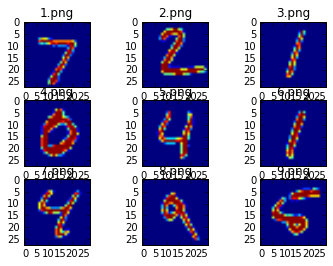

In [18]:
plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)  
    plt.title(str(i+1) + ".png")
    im = np.array((mnist.test.images[i,:] * 255)).reshape(28,-1)  
    plt.imshow(im)
plt.show()